# Projet traitement du signal

DESCHAMPS Samuel, HUBAULT Killian, MAESTRI Raphaël

---

# Livrable 4


### Introduction :

Lors d'une mission de l'agence **AIL3C**, l'**Agence Indépendante de Lutte Contre la CyberCriminalité**, un agent ayant réussi à infiltrer une base se trouve dans une situation délicate : celui-ci se trouve bloqué dans une salle de conférence. L’agent n’a pas encore été repéré grâce à son **masque-peau** mais celui-ci se trouve dans l’incapacité de communiquer avec l’extérieur et ne peut accéder qu’indirectement à un micro branché au système d'audioconférence, uniquement connecté au réseau lors de l'utilisation de la salle de conférence. Cependant nous disposons d'une **cellule d'écoute** infiltrée sur le réseau ce qui nous permet d'avoir accès à l'enregistrement du micro de la salle de conférence.

Nous devons ici réaliser le programme décrivant la chaine de transmission reliant l'**agent K-57** et **cellule d'écoute** de l'agence **AIL3C**. 

### Objectifs :

Réaliser la chaine de transmition du livrable 3 sous python.

### Table des matières :

- Emission du signal
- Codage Manchester 
- Protocole RSK de notre création
- Calcul du CRC
- Modulation FSK OU ASK
- Démodulation FSK OU ASK
- Décodage du protocole RSK
- Vérification du CRC
- Décodage Manchester
- Décodage ASCII
- Conclusion

In [1]:
# On importe les bibliothèques nécessaire
import numpy as np
import matplotlib.pyplot as plt
import random
import soundfile as sf
import sounddevice as sd
from scipy.io import wavfile

#### Pad agent - Emission du signal

In [2]:
# Le message à transmettre sous forme de chaine de caractères
M = "MAYDAY-K57"

# Les commentaires ci-dessous sont des messages alternatifs de taille diférentes et avec des caractères différents
# M = "MAYDAY-K57" * 200
# M = "abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ 0123456789 éèêàùë,;:!?./§ù*^$%µ¨£&'(-_ç)="
# M = "!#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡¢£¤¥¦§¨©ª«¬­®¯°±²³´µ¶·¸¹º»¼½¾¿ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿ"
# M = "A l aide"
print(M)

# Le message est codé par ascii
M_ascii_str_bin = ""
for lettre in M:  # Pour chaque lettre du message 
    decimal = ord(lettre)  # Conversion de la lettre en décimal
    binaire = f"{decimal:08b}"  # Conversion décimal binaire sur 8 bits
    
    # print(lettre, decimal, binaire)
    M_ascii_str_bin += binaire

print(M_ascii_str_bin)

# Conversion du message binaire string en message binaire liste
M_ascii_liste = []
for x in M_ascii_str_bin:
    M_ascii_liste.append(int(x))

# print(M_ascii_liste)

MAYDAY-K57
01001101010000010101100101000100010000010101100100101101010010110011010100110111


##### Codage Manchester 

160
<class 'str'>


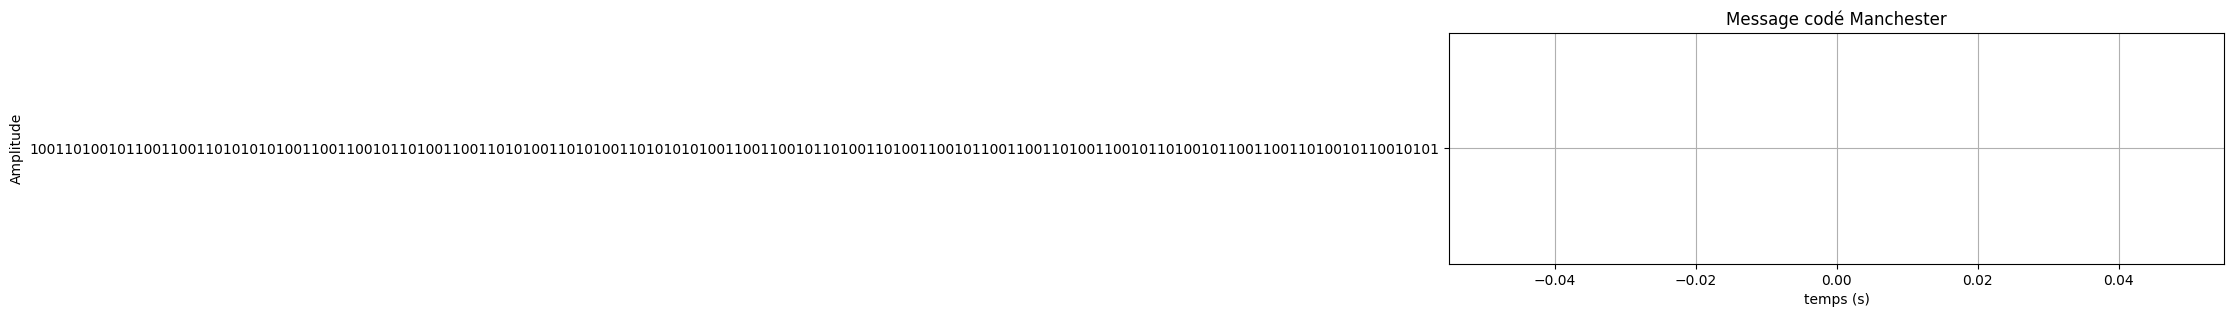

In [66]:
# Codage de Manchester
def codage_bi_manchester(M_ascii_liste):
    M_ascii_codage_manchester = ""
    for i in range(0, len(M_ascii_liste)):
        if M_ascii_liste [i] == 0:
            M_ascii_codage_manchester += "10"
        elif M_ascii_liste [i] == 1:
            M_ascii_codage_manchester += "01"

        else:
            print ("Bit inconnu on ne peut pas coder en manchester")
            plt.figure(figsize=(10, 3))

    return M_ascii_codage_manchester    

M_ascii_codage_manchester = codage_bi_manchester(M_ascii_liste)
print (len(M_ascii_codage_manchester))
print (type(M_ascii_codage_manchester))
np.astype(M_ascii_codage_manchester)

M_ascii_manchester_liste = []
for x in M_ascii_codage_manchester:
    M_ascii_manchester_liste.append(int(x)) 

plt.figure(figsize=(10, 3))
plt.title("Message codé Manchester")
plt.plot(codage_bi_manchester(M_ascii_liste))    
plt.xlabel("temps (s)")
plt.ylabel("Amplitude")
plt.grid()

##### Transmission protocole RSK

Nous utiliserons un nouveau protocole que nous appellerons RSK (Raphaël Samuel et Killian). Ce protocole permet de définir la façon dont les données seront ordonnées dans les trames de données.

| Trame             | Flag début | Destinataire | Expéditeur | Données   | FCS | Flag fin |
|-------------------|------------|--------------|------------|-----------|-----|----------|
| Taille (octets)   | 1          | 1            | 1          | 1 à 15000 | 1   | 1        |
| Valeur par défaut | 11000011   | 01010101     | 00111001   | ...       | ... | 11000011 |


Le Flag de début et de fin sera : **01111110**

Le destinataire et l'expéditeurs ont un code :
- Expéditeur (agent K57) -> **00111001** (57 en binaire)
- Destinataire (équipe d'intervention) -> **01010101** (85 en binaire)

Les données seront sous forme d'octets avec au maximum un **total de 1500** octets.

Ensuite il y a le code FCS (Frame Checking Sequence). Ce code permet d'assurer la fiabilité des données. Nous utiliserons ici un code crc. Ce code est le reste d'opérations en ou-exclusifs (xor) successifs sur toute la trame sauf les flags. En répétant ce calcul et en incluant le nouveau code crc le résultat sera toujours 0 à moins que la trame n'ait été altérée. Nous pourrons donc vérifier si les données ont été altérées. on choisit d'utiliser un diviseur constant de 9 bits: **11000011**

Enfin, le flag de fin permet de finir le message.

##### Codage de Hamming

Au lieu d'utiliser le crc, on utilise l'algorithme de Hamming qui corrige les erreurs

In [5]:
# Fait un xor bit par bit de la représentation binaire des éléments d'une liste
def xor_liste_str(liste, nombre_bits):
    resultat = "0" * nombre_bits
    for entier in liste:
        binaire = f"{entier:08b}"
        # print(binaire)
        resultat = "".join(
            [
                "0" if bit == resultat[index_bit] else "1"
                for index_bit, bit in enumerate(binaire)
            ]
        )
    return resultat


# Prend une chaine de caractère contenant tous les bits à transmettre et la sépare en blocs de Hamming
def encodage_hamming(donnees):
    longueur_totale = 64
    pas_max = 48
    bits_taille = 8

    index_fin = min(pas_max, len(donnees))
    longueur = index_fin
    # print("i:", i, "index_fin:", index_fin, "longueur:", longueur)

    longueur_binaire = f"{longueur:08b}"
    # print(longueur_binaire)

    donnees_binaire = longueur_binaire + donnees[:index_fin] + "0"
    # donnees_binaire = "11100101101"  # Exemple de valeurs

    # Conversion de la chaine de caractères binaire en liste binaire
    donnees_binaire_list = [int(bit) for bit in donnees_binaire]

    # On ajoute un 0 au début de la liste
    donnees_binaire_list.insert(0, 0)
    # On ajoute des 0 aux positions dont l'index est multiple de 2: 1, 2, 4, 8...
    for j in range(0, 6):
        index_bit_hamming = 2**j
        donnees_binaire_list.insert(index_bit_hamming, 0)
        # print(index_bit_hamming)

    # On modifie ces nombres pour assurer la parité
    for j in range(0, 6):
        # print(donnees_binaire_list)
        index_bit_hamming = 2**j

        # Compte le nombre de 1 en ne prenant que les nombres dont le bit index_bit vaut 1 dans la représentation binaire de son indice
        nombre_1_correspondant = len(
            [
                index_bit
                for index_bit, bit in enumerate(donnees_binaire_list)
                if bit == 1 and f"{index_bit:08b}"[7 - j] == "1"
            ]
        )
        if nombre_1_correspondant % 2 != 0:
            # print("Bit d'Hamming mis à 1 à l'index:", index_bit_hamming)
            donnees_binaire_list[index_bit_hamming] = 1

    # print(donnees_binaire_list)

    # Liste des l'index binaires de chaque 1 dans les données
    liste_indexs_1 = [
        index_bit for index_bit, bit in enumerate(donnees_binaire_list) if bit == 1
    ]
    # print(liste_indexs_1)

    resultat_xor = xor_liste_str(liste_indexs_1, 8)
    # print("XOR:", resultat_xor)

    # On convertit la liste en chaîne de données
    donnees_encodees = "".join([str(bit) for bit in donnees_binaire_list])
    return donnees_encodees


# Prend une chaine de caractère contenant tous les bits à transmettre et la sépare en blocs de Hamming
def decodage_hamming(donnees_encodees):
    longueur_totale = 64
    pas_max = 48
    bits_taille = 8

    index_fin = min(longueur_totale, len(donnees_encodees))
    # longueur = index_fin - i
    # print("i:", i, "index_fin:", index_fin, "longueur:", longueur)

    # Conversion de la chaine de caractères binaire en liste binaire
    donnees_binaire_list = [int(bit) for bit in donnees_encodees[:index_fin]]

    # Liste des l'index binaires de chaque 1 dans les données
    liste_indexs_1 = [
        index_bit for index_bit, bit in enumerate(donnees_binaire_list) if bit == 1
    ]
    # print(liste_indexs_1)

    resultat_xor = xor_liste_str(liste_indexs_1, 8)
    # print("XOR:", resultat_xor)

    resultat_xor_decimal = int(resultat_xor, 2)
    if resultat_xor_decimal != 0:  # Il faut inverser le bit à l'index resultat_xor_decimal
        print("Correction hamming à l'index:", resultat_xor_decimal)
        if donnees_binaire_list[resultat_xor_decimal] == 0:
            donnees_binaire_list[resultat_xor_decimal] = 1
        else:
            donnees_binaire_list[resultat_xor_decimal] = 0

    # On retire les bits aux positions dont l'index est multiple de 2: 1, 2, 4, 8...
    for j in reversed(range(0, 6)):
        index_bit_hamming = 2**j
        donnees_binaire_list.pop(index_bit_hamming)
        # print(index_bit_hamming)
    donnees_binaire_list.pop(0)

    longueur = int("".join(str(x) for x in donnees_binaire_list[:bits_taille]), 2)
    # print("longueur", longueur)
    donnees_decodees = "".join(
        [str(bit) for bit in donnees_binaire_list[bits_taille : bits_taille + longueur]]
    )
    return donnees_decodees

##### Protocole RSK et calcul du CRC et codage de Hamming

In [6]:
# Fait le xor de deux chaînes de caractères contenant des bits
def xor(a: str, b: str):
    # On initialise le résultat
    resultat = ""
 
    # Parcourt chaque bit pour faire le xor (bits identique -> 0, sinon -> 1)
    for i in range(1, len(b)):
        if a[i] == b[i]:
            resultat += "0"
        else:
            resultat += "1"
 
    return resultat

# Créé le CRC de données binaires (chaîne de caractères)
def creer_crc(donnees: str, diviseur: str):
    n = len(diviseur)  # n est la longueur du diviseur
    donnees += "0" * (n - 1)  # Ajoute (n-1) zeros à la fin des données
    
    x = n  # Nombre de bits sur lesquels faire un xor
    # On récupère le bon nombre de bits des donnees
    reste = donnees[0:n]
    while x < len(donnees):
        if reste[0] == '1':  # Si le premier bit de reste est un 1
            # Calcule le xor de reste et des données puis on ajoute le prochain bit (donnees[x])
            reste = xor(diviseur, reste) + donnees[x]
        else: # Si le premier bit de reste est un 0
            # Calcule le xor de reste et de x fois 0 puis on ajoute le prochain bit (donnees[x])
            reste = xor("0" * n, reste) + donnees[x]

        # On imcrémente le nombre de bits sur lesquels faire le xor
        x += 1
    # Pour les derniers bits, on arrête d'ajouter des valeurs de données
    if reste[0] == '1':
        reste = xor(diviseur, reste)
    else:
        reste = xor("0" * x, reste)
 
    return reste


adresse_agent = "00111001"  # 57 -> Code de l'Agent k57
adresse_equipe = "01010101"  # 85 -> Code de l'équipe d'intervention
taille_max = 4 * 8  # Nombre de bits de données max (4 octets = 32 bits)
diviseur = "110011111"  # On choisit un diviseur de 9 bits pour avoir un crc de 9-1 = 8 bits
flag = "01111110"

trames_assemblees_str = ""  # Liste contenant toutes les trames de données

# Parcourt les données avec un pas de taille_max octets
for i in range(0, len(M_ascii_codage_manchester), taille_max):
    trame = adresse_equipe + adresse_agent  # On pré-remplit le début de la trame
    
    # Index de la dernière donnée à récupérer (i + taille_max, sauf si on arrive à la fin de la liste)
    fin_donnees = min(i + taille_max, len(M_ascii_codage_manchester))
    
    donnees_trame = M_ascii_codage_manchester[i:fin_donnees]  # On récupère les données que va devoir stocker la trame
    
    trame += donnees_trame
    print("Trame sans Hamming:", trame)
    
    # Au lieu d'ajouter un crc, on utilise l'algorithme d'Hamming afin de corriger aitomatiquement les intefércences d'un bit
    trame = encodage_hamming(trame)
    print("Trame sans flags:", trame)
    
    # Calcul du crc de la trame sans les flags
    # crc = creer_crc(trame, diviseur)
    # trame += crc
    
    
    # Affichage des 4 premières trames
    # if i // taille_max < 5:
    #     print(f"trame {trame}, crc {crc} -> {creer_crc(trame+crc, diviseur)}")
    
    trame = flag + trame + flag
    trames_assemblees_str += trame
    # print("Trame:", trame)
    
    # Ajout d'interférences entre les trames (20 binaires aléatoires inutiles) entre les trames
    # Nombre aléatoire valant "0" ou "1"
    bit_aleatoire = "0" if random.randint(0, 1) == 0 else "1"
    for x in range(20):
        trames_assemblees_str += bit_aleatoire

trames_assemblees_list = [int(bit) for bit in trames_assemblees_str]
print("Longueur totale des trames:", len(trames_assemblees_str))

# Affichages des trames si on les découpe sur leurs flags
# print()
# print(*"".join([str(bit) for bit in trames_assemblees_list]).split(flag)[1::2], sep="\n")

Trame sans Hamming: 010101010011100110011010010110011001101010101001
Trame sans flags: 0110001100000010110101001110011010110100101100110011010101010010
Trame sans Hamming: 010101010011100110011001011010011001101010011010
Trame sans flags: 0110001100000010110101001110011010110010110100110011010100110100
Trame sans Hamming: 010101010011100110011010101010011001100101101001
Trame sans flags: 0110001100000010110101001110011010110101010100110011001011010010
Trame sans Hamming: 010101010011100110100110010110011001101001100101
Trame sans flags: 0110101110000010110101001110011011001100101100110011010011001010
Trame sans Hamming: 010101010011100110100101100110011010010110010101
Trame sans flags: 0000001110000010110101001110011011001011001100110100101100101010
Longueur totale des trames: 500


##### Modulation FSK

500 * 220 = 110000
Longueur porteuses : porteuse 1 -> (110000,), porteuse 2 -> (110000,)


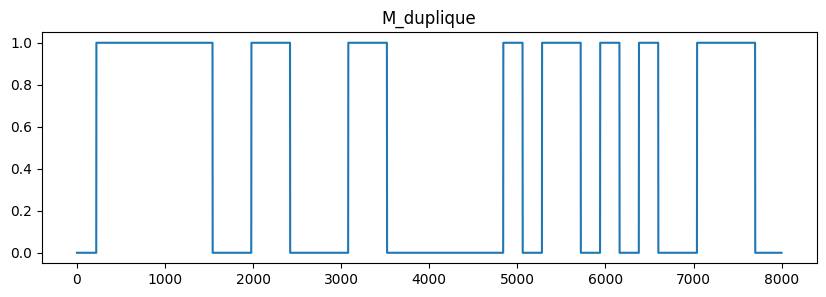

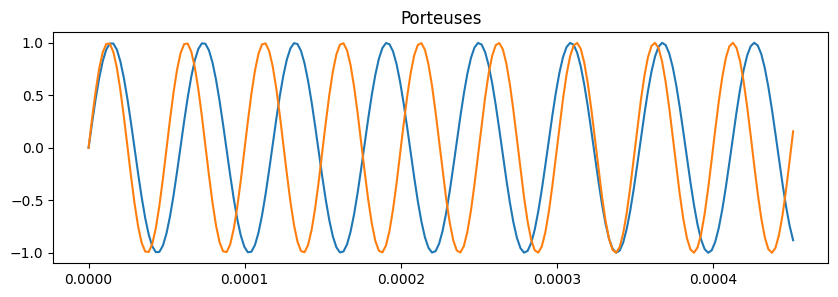

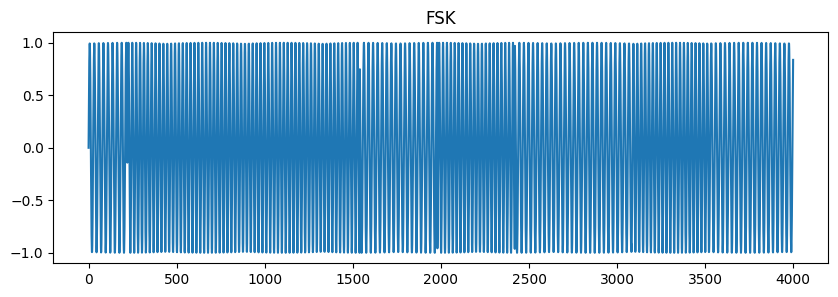

In [58]:
def modulation_fsk(trames):
	# Création d'une liste dont chaque caractère est répété Ns fois
	Ns = 220
	N = len(trames) * Ns
	print(len(trames), "*", Ns, "=", N)
	M_duplique = np.repeat(trames, Ns)
	# print(M_duplique)
	# print(f"N: {N}")

	# Création du vecteur temps
	Fe = 44100
	t = np.linspace(0, N / Fe / 10, N)
	# print(t.shape, t)

	# plt.figure(figsize=(10, 3))
	# plt.title("M_duplique")
	# plt.plot(M_duplique[:200])

	# Création des porteuses
	Fp1 = 17000
	Ap1 = 1
	Fp2 = 20000
	Ap2 = 1
	porteuse1 = Ap1 * np.sin(2 * np.pi * Fp1 * t)
	porteuse2 = Ap2 * np.sin(2 * np.pi * Fp2 * t)
	print(f"Longueur porteuses : porteuse 1 -> {porteuse1.shape}, porteuse 2 -> {porteuse2.shape}")

	# Modulation de notre message
	fsk = []
	for i in range(N):
		if M_duplique[i] == 0:  # 0
			fsk.append(porteuse1[i])
		else:  # 1
			fsk.append(porteuse2[i])

	plt.figure(figsize=(10, 3))
	plt.title("M_duplique")
	plt.plot(M_duplique[:8000])


	plt.figure(figsize=(10, 3))
	plt.title("Porteuses")
	plt.plot(t[:200], porteuse1[:200])
	plt.plot(t[:200], porteuse2[:200])

	plt.figure(figsize=(10, 3))
	plt.title("FSK")
	plt.plot(fsk[:4000])

	return fsk

fsk = modulation_fsk(trames_assemblees_list)

Une fois notre message modulé par le pad de l'agent on l'envoie dans la salle de conférence à une fréquence non-audible.

Ce signal sera capté par le micro de la salle et envoyé dans le réseau.

La cellule d'écoute récupère ce signal et le démodule de la façon suivante :

On peut aussi faire une modulation ASK à la place de la modulation FSK.

##### Modulation ASK

110000


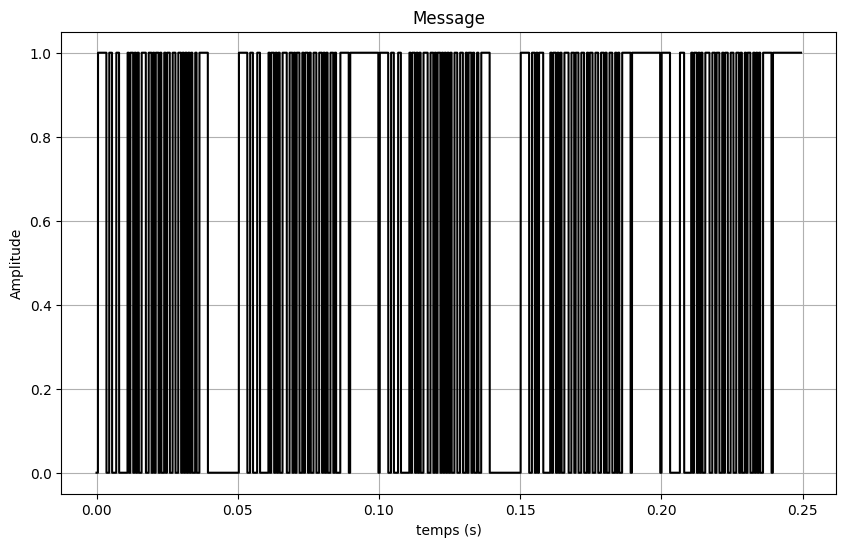

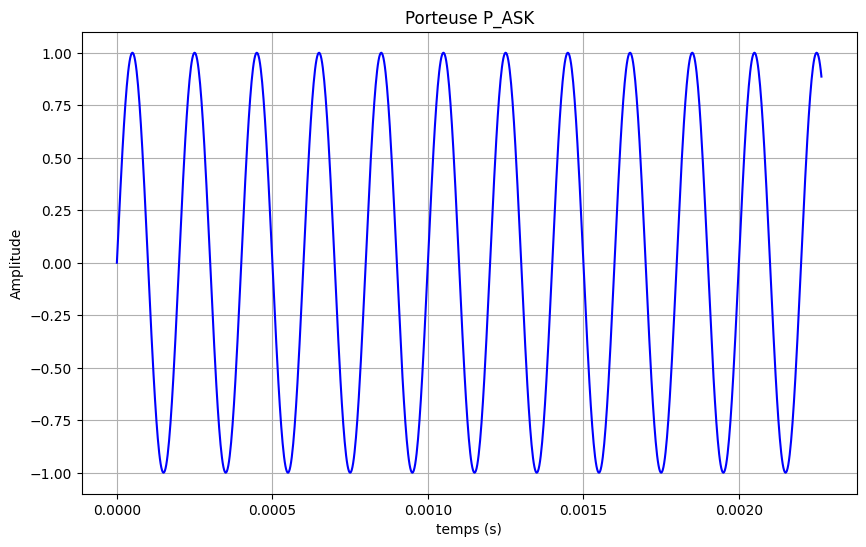

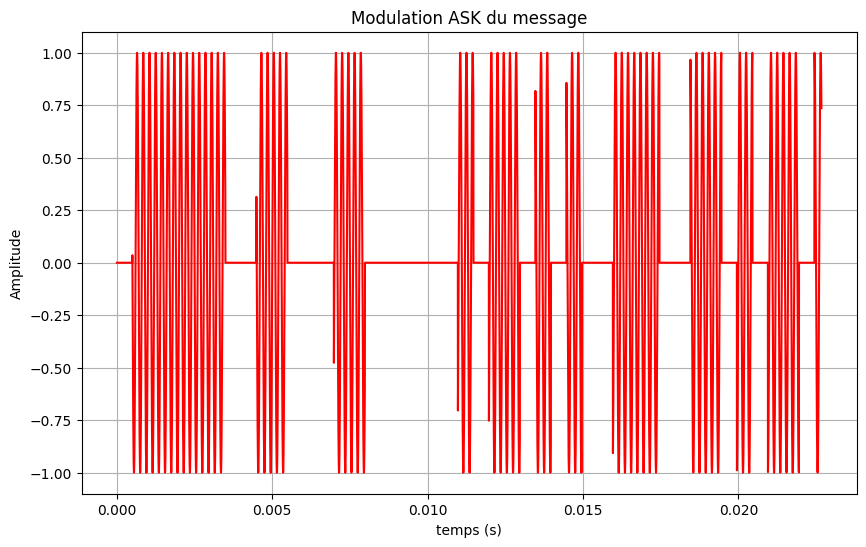

In [54]:
# Foction de modulation ASK

def ASK(trames_assemblees_list):
    # Génération du vecteur temps
    Ns = 220
    N = len(trames_assemblees_list) * Ns
    Fe = 44100

    t = np.linspace(0, N / Fe / 10, N)
    print(t.size)

    # Génération de la porteuse

    Fp_ASK = 5000
    Ap = 1
    P_ASK = Ap * np.sin(2 * np.pi * Fp_ASK * t)

    # Notre message à moduler est M_duplique

    M_duplique = np.repeat(trames_assemblees_list, Ns)
    # print(P_ASK.size, M_duplique.size)

    ask = M_duplique * P_ASK  #  formule de la modulation ASK
    # Affichage du message original M_duplique(t)

    plt.figure(figsize=(10, 6))
    plt.plot(t, M_duplique, "black")
    plt.title("Message")
    plt.xlabel("temps (s)")
    plt.ylabel("Amplitude")
    plt.grid()

    # Affichage de la porteuse P_ASK(t)

    plt.figure(figsize=(10, 6))
    plt.plot(t[:1000], P_ASK[:1000], "blue")
    plt.title("Porteuse P_ASK")
    plt.xlabel("temps (s)")
    plt.ylabel("Amplitude")
    plt.grid()

    # Affichage du résultat de la modulation ask(t)

    plt.figure(figsize=(10, 6))
    plt.plot(t[:10000], ask[:10000], "red")
    plt.title("Modulation ASK du message")
    plt.xlabel("temps (s)")
    plt.ylabel("Amplitude")
    plt.grid()
    return ask

ask = ASK(trames_assemblees_list)



Dans le cas où le message est modulé ASK la cellule d'écoute doit le démoduler de la façcon suivante :

##### Enregistrement et écoute du signal modulé

In [53]:
def creer_un_fichier_son(signal):
    Fe = 44100
    wavfile.write("son_module.wav",Fe,np.asarray(signal))

def jouer_le_son(signal):
    Fe = 44100
    sd.play(np.asarray(signal), Fe)
    status = sd.wait()

# creer_un_fichier_son(fsk)
#jouer_le_son(fsk)
# creer_un_fichier_son(ask)
jouer_le_son(ask)

#### Ordinateur de l'équipe d'intervention - Réception du signal

Nous devons maintenant inverser chaque étape afin de retrouver le message original.

##### Démodulation FSK

Longueur porteuses : porteuse 1 -> (110000,), porteuse 2 -> (110000,)


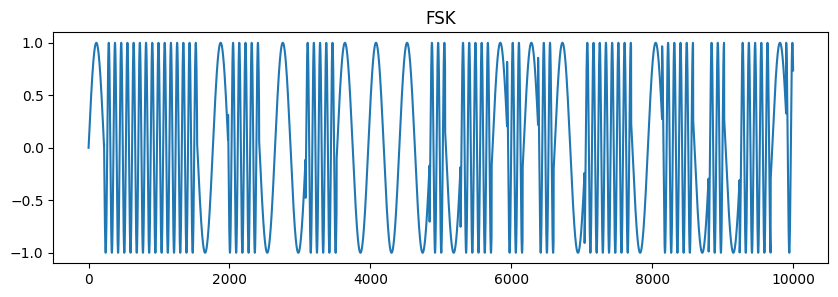

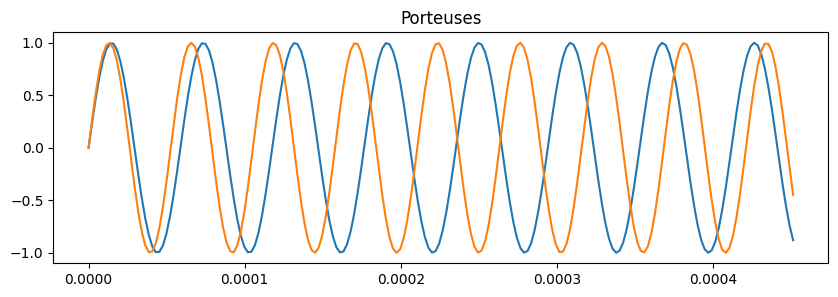

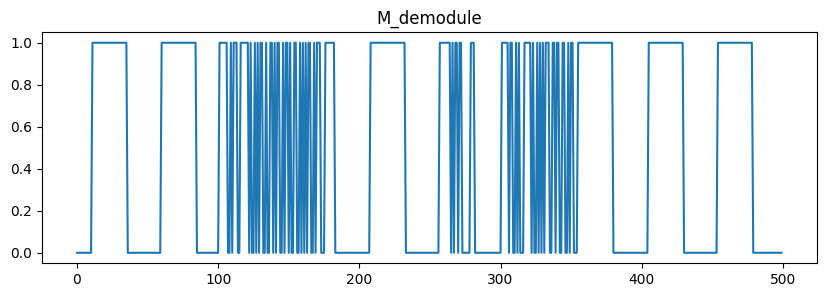

In [46]:
def demodulation_fsk(fsk):
	# Création d'une liste dont chaque caractère est répété Ns fois
	Ns = 220
	N = len(fsk)

	# Création du vecteur temps
	Fe = 44100
	t = np.linspace(0, N / Fe / 10, N)

	# Création des porteuses
	Fp1 = 17000
	Ap1 = 1
	Fp2 = 19000
	Ap2 = 1
	porteuse1 = Ap1 * np.sin(2 * np.pi * Fp1 * t)
	porteuse2 = Ap2 * np.sin(2 * np.pi * Fp2 * t)
	print(
		f"Longueur porteuses : porteuse 1 -> {porteuse1.shape}, porteuse 2 -> {porteuse2.shape}"
	)

	# Produit de chacune des porteuses avec fsk
	produit1 = fsk * porteuse1
	produit2 = fsk * porteuse2

	# Calcul de l'intégrale de période Ns avec chacun des produits
	res1 = []
	res2 = []
	for i in range(0, N, Ns):
		res1.append(np.trapz(produit1[i : i + Ns], t[i : i + Ns]))
		res2.append(np.trapz(produit2[i : i + Ns], t[i : i + Ns]))

	# Comparaison des deux intégrales (res1 est res2)
	M_demodule = []
	for i in range(len(res1)):
		if res1[i] > res2[i]:
			M_demodule.append(0)
		else:
			M_demodule.append(1)
	# print("M_demodule:", M_demodule)

	plt.figure(figsize=(10, 3))
	plt.title("FSK")
	plt.plot(fsk[:10000])

	plt.figure(figsize=(10, 3))
	plt.title("Porteuses")
	plt.plot(t[:200], porteuse1[:200])
	plt.plot(t[:200], porteuse2[:200])

	plt.figure(figsize=(10, 3))
	plt.title("M_demodule")
	plt.plot(M_demodule[:min(500, len(M_demodule))])
 
	return M_demodule

M_demodule = demodulation_fsk(fsk)

##### Démodulation ASK

In [45]:
def demodulation_ask(ask):
    # Création d'une liste dont chaque caractère est répété Ns fois
    N = len(trames_assemblees_list)
    Fe = 44100
    Ns = 220

    Ns = 220
    N = len(ask)
    Fe = 44100

    # Vecteur temps
    t = np.linspace(0, N / Fe / 10, N)

    # On réutilise la poteuse P_ASK utilisé pour moduler
    Fp_ASK = 19000
    Ap = 1
    P_ASK = Ap * np.sin(2 * np.pi * Fp_ASK * t)

    # Produit
    produit = ask * P_ASK

    # Intégration par la méthode des Trapèzes
    res = []
    for i in range(0, N, Ns):
        res.append(np.trapz(produit[i : i + Ns]))

    # Comparateur
    M_demodule = []

    for i in range(len(res)):
        if res[i] > 0:
            M_demodule.append(1)
        else:
            M_demodule.append(0)

    # Affichage du message reçu modulé ask (t)
    plt.figure(figsize=(10, 3))
    plt.title("Message Modulé ASK")
    plt.plot(ask[:200])

    # Affichage de la porteuse P_ASK (t)
    plt.figure(figsize=(10, 3))
    plt.title("Porteuses")
    plt.plot(t[:200], P_ASK[:200])

    # Affichage du message démodulé ask (t)
    plt.figure(figsize=(10, 3))
    plt.title("Message démodulé")
    plt.plot(M_demodule[:200])

    return M_demodule

# Commenter la ligne suivante pour ne pas utiliser la démodulation ASK
# M_demodule = demodulation_ask(ask)

# print(M_demodule)

Une fois le message démodulé on obtient une liste de valeur binaire. Notre signal se situe entre les fanions [1, 1, 0, 0, 0, 0, 1, 1]. 
Le décodage de notre protocole va permettre de repérer clairement nos données et éliminer les valeurs en dehors des fanions. On a ajouté 20bits de données aléatoire à la fin du message pour montrer cela.

##### Altération d'une donnée

On altère le 20ème bit pour prouver que le message se corrige automatiquement grâce à l'algorithme de Hamming.

In [32]:
# Conversion de la liste de valeurs binaires en simple chaîne de caractères
M_demodule_str = "".join([str(bit) for bit in M_demodule])

# On inverse le 20ème bit pour prouver l'efficacité du codage de Hamming
if M_demodule[20] == 1:
	M_demodule[20] = 0
else:
	M_demodule[20] = 1

##### Décodage du protocole RSK et ~~vérification du CRC~~ décodage de Hamming

In [33]:
# Verification de l'altération de donnée lors de la modulation/démodulation
# print("Modulation/démodulation réussie:", trames_assemblees_list == M_demodule)


flag = "01111110"
diviseur = "110011111"
adresse_agent = "00111001"  # 57 -> Code de l'Agent k57
adresse_equipe = "01010101"  # 85 -> Code de l'équipe d'interventiontrames_assemblees_list

# On découpe le string en retirant les flags
# On obtient donc une liste de trames
M_sans_flag = M_demodule_str.split(flag)[1::2]
print(M_sans_flag[:5])

# On n'a plus besoin du crc car on utilise l'algorithme de Hamming
# donnees_toutes_trames = []
# for trame_avec_crc in M_sans_flag:
#     resultat_crc = creer_crc(trame_avec_crc, diviseur)
#     if int(resultat_crc) != 0:  # Si les données sont altérées pendant la transmission
#         # On envoie un message d'erreur et on n'exploite pas les données
#         print("Le résultat avec le crc n'est pas 0:", resultat_crc)
#     else:
# 		# On retire le crc en fin de trame
#         trame = trame_avec_crc[:len(trame_avec_crc) - 8]
#         destinataire = trame[:8]
#         expediteur = trame[8:16]
#         donnees_trame = trame[16:]
#         # Si nous sommes bien le destinataire et que l'agent est l'expéditeur
#         if destinataire == adresse_equipe and expediteur == adresse_agent:
#             for bit in donnees_trame:
#                 donnees_toutes_trames.append(int(bit))
#         else:  # Si nous ne sommes pas le destinataire ou que l'agent n'est pas l'expéditeur
#             print("Destinataire ou expéditeur incorrect lors de la réception: destinataire ->", destinataire, "expediteur ->", expediteur)

donnees_toutes_trames = []
for trame_encodees_hamming in M_sans_flag:
    # resultat_crc = creer_crc(trame_encodees_hamming, diviseur)
    
    # On décode avec Hamming
    trame = decodage_hamming(trame_encodees_hamming)
    # print("Décodage d'une trame de longueur", len(trame))
    
    destinataire = trame[:8]
    expediteur = trame[8:16]
    donnees_trame = trame[16:]
    # 010101010011100110011010010110011001101010101001
    # 12345678123456781001101001011001100110101010100
    
    # Si nous sommes bien le destinataire et que l'agent est l'expéditeur
    if destinataire == adresse_equipe and expediteur == adresse_agent:
        for bit in donnees_trame:
            donnees_toutes_trames.append(int(bit))
    else:  # Si nous ne sommes pas le destinataire ou que l'agent n'est pas l'expéditeur
        print("Destinataire ou expéditeur incorrect lors de la réception: destinataire ->", destinataire, "expediteur ->", expediteur)

print(donnees_toutes_trames[:20])


print(trames_assemblees_list[:100])
print(donnees_toutes_trames[:100])

['0110001100000010110101001110011010110100101100110011010101010010', '0110001100000010110101001110011010110010110100110011010100110100', '0110001100000010110101001110011010110101010100110011001011010010', '0110101110000010110101001110011011001100101100110011010011001010', '0000001110000010110101001110011011001011001100110100101100101010']
[1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
[0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,

Une fois qu'on s'est assuré de ne pas avoir d'erreurs de transmission grâce au CRC on peut faire le décodage Manchester

##### Décodage Manchester

In [34]:
# Bi-phase Manchester: 2 bits pour chaque donnée: 10 -> 0 et 01 -> 1
def decodage_bi_manchester(donnees_toutes_trames):
    M_ascii_decodage_manchester = []
    for i in range(0, len(donnees_toutes_trames), 2):
        if donnees_toutes_trames[i] == 1 and donnees_toutes_trames[i + 1] == 0:  # 10 -> 0
            M_ascii_decodage_manchester.append(0)
        elif donnees_toutes_trames[i] == 0 and donnees_toutes_trames[i + 1] == 1:  # 01 -> 1
            M_ascii_decodage_manchester.append(1)
        else:
            print("Le bit de rang", i, "n'est pas déchiffrable")
    return M_ascii_decodage_manchester

M_ascii_decodage_manchester = decodage_bi_manchester(donnees_toutes_trames)

print(M_ascii_decodage_manchester[:min(40, len(M_ascii_decodage_manchester))])

[0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]


On utilise la finalement la table ASCII pour récupérer notre message en lettre :

#### Décodage ASCII

In [35]:
# nombre_de_lettre = len(M_ascii_decodage_manchester) / 8
def decodage_ASCII(M_ascii_decodage_manchester):
    message_decode = ""
    for i in range(0, len(M_ascii_decodage_manchester), 8):
        octet = M_ascii_decodage_manchester[i : i + 8]
        decimal = 0
        # on convertit octet en chaine de caractère pour pouvoir utiliser le fonction int
        for j in range(8):  
            decimal += octet[7 - j] * (2**j)
        # print(decimal, octet)

        lettre = chr(decimal)

        # print(lettre)

        message_decode += lettre
        # print(message_decode)

    return message_decode

message_decode = decodage_ASCII(M_ascii_decodage_manchester)
print(message_decode)

MAYDAY-K57


## Conclusion

Pour conclure, notre proposition de résolution est divisible en deux ensembles :

Le premier ensemble représente la mise en place d'une émission d'un signal de détresse pouvant être récupéré par l'agence.
Cette partie met alors en place un système de création d'un signal, inaudible via des ultrasons, représentant un texte.
Le texte subit alors les transformations suivantes :

- Conversion Ascii puis Binaire
- Codage Binaire en Manchester
- Instauration d'un Protocole RSK de notre création
- Calcul de la méthode CRC de vérification d'erreurs
- Modulation FSK OU ASK

Le second ensemble à notre programme représente l'ordinateur chargé de recevoir l'émission du l'agent K-57 en étant connecté à la salle conférence via le réseau électrique.
Nous devons alors procéder à la manière opposé d'une émission pour obtenir le message d'origine : 

- Démodulation FSK OU ASK
- Décodage du protocole RSK
- Vérification du CRC
- Décodage Manchester
- Décodage ASCII
- Récupération du message de détresse

Parmi les fonctionnalités additionnelles proposées, nous avons implémenté:
- La possibilité de faire ce traitement depuis 2 ordinateurs (émetteur/receveur)
- Une modulation ASK est disponible en plus de la modulation FSK utilisée par défaut

Avec ce gadget, l'agent K57 n'aurait eu aucun problème à s'exfiltrer.